In [1]:
import warnings
warnings.filterwarnings("ignore")

Create Dataset

In [2]:
import pandas as pd
import numpy as np

first_df=pd.read_csv('Arrests_cleaned.csv')

In [3]:
import requests, json
r = requests.get('https://data.cityofchicago.org/resource/crimes.json?$limit=600000')
data = r.json()
sec_df = pd.DataFrame(data)
sec_df = sec_df[['case_number','ward','district']]

In [4]:
merged_df = pd.merge(first_df, sec_df, on="case_number")
print(len(merged_df))
merged_df.head(1)

68416


,id,case_number,date_month,date_day,date_year,time,meridiem,race,charge_1_statute,charge_1_description,...,charge_4_statute,charge_4_description,charge_4_type,charge_4_class,CHARGES STATUTE,CHARGES DESCRIPTION,CHARGES TYPE,CHARGES CLASS,ward,district
0,30039812,JE183770,3,30,2021,12:10:00,AM,WHITE HISPANIC,720 ILCS 5.0/12-3.2-A-1,DOMESTIC BATTERY - BODILY HARM,...,NaN,NaN,NaN,NaN,720 ILCS 5.0/12-3.2-A-1 | | |,DOMESTIC BATTERY - BODILY HARM | | |,M | | |,A | | |,14,008


In [5]:
races = merged_df.loc[:, "race"].unique().tolist()
race_dummies = pd.get_dummies(merged_df, columns=["race"])
races = ["race_"+r for r in races]
race_dummies = race_dummies[races]
race_dummies

,race_WHITE HISPANIC,race_BLACK,race_BLACK HISPANIC,race_WHITE,race_ASIAN / PACIFIC ISLANDER,race_AMER INDIAN / ALASKAN NATIVE,race_UNKNOWN / REFUSED
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
68411,0,0,1,0,0,0,0
68412,0,1,0,0,0,0,0
68413,0,1,0,0,0,0,0
68414,1,0,0,0,0,0,0


In [6]:

merged_df = merged_df[['ward','district','date_day','date_year','charge_1_type']]

merged_df = pd.concat([merged_df, race_dummies], axis=1).dropna()

In [7]:
merged_df

,ward,district,date_day,date_year,charge_1_type,race_WHITE HISPANIC,race_BLACK,race_BLACK HISPANIC,race_WHITE,race_ASIAN / PACIFIC ISLANDER,race_AMER INDIAN / ALASKAN NATIVE,race_UNKNOWN / REFUSED
0,14,008,30,2021,M,1,0,0,0,0,0,0
1,22,010,23,2021,M,0,1,0,0,0,0,0
2,7,004,16,2021,F,0,1,0,0,0,0,0
3,24,011,16,2021,F,0,1,0,0,0,0,0
4,13,008,16,2021,M,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
68411,22,010,7,2022,F,0,0,1,0,0,0,0
68412,34,022,7,2022,M,0,1,0,0,0,0,0
68413,9,005,7,2022,F,0,1,0,0,0,0,0
68414,7,003,7,2022,F,1,0,0,0,0,0,0


In [37]:
from sklearn.model_selection import train_test_split

X = merged_df[['race_WHITE HISPANIC','race_BLACK','race_BLACK HISPANIC','race_WHITE','race_ASIAN / PACIFIC ISLANDER','race_AMER INDIAN / ALASKAN NATIVE', \
    'race_UNKNOWN / REFUSED','ward','district','date_day','date_year']]
y = merged_df[['charge_1_type']]

#### Ensemble

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2)
y_bool_train = [i == "M" for i in y_train['charge_1_type']]
y_bool_test = [i == "M" for i in y_test['charge_1_type']]

In [57]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [54]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy')
decision_tree_model.fit(X_train, y_bool_train)
y_pred = decision_tree_model.predict(X_test)
cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
cv_results

{'fit_time': array([0.16573787, 0.16132712, 0.16025114, 0.16142225, 0.16346812]),
 'score_time': array([0.0195322 , 0.01916599, 0.01905322, 0.01932597, 0.01907992]),
 'test_score': array([0.57610086, 0.56820466, 0.56957515, 0.56994061, 0.57697579])}

In [89]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy')
best_depth = []
best_min_samples = []
best_nodes = [] 

for i in range(1,21):
    decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = i)
    decision_tree_model.fit(X_train, y_bool_train)
    y_pred = decision_tree_model.predict(X_train)
    cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
    score = np.mean(cv_results['test_score'])
    best_min_samples.append(score)
    print(score)

0.5480392845078506
0.57122761457738
0.5917113848564451
0.5948909806578195
0.6001351290779429
0.6008660914993051
0.6084675808322545
0.6114095317542482
0.6100756661068912
0.6080108363687782
0.6058363675260512
0.6016335568846342
0.5953658697620788
0.5945071503056201
0.591364221068801
0.5852610693952796
0.5820998903458708
0.5779702241920698
0.5757591939565943
0.5757226492577833


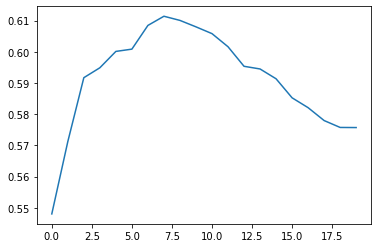

In [90]:
import matplotlib.pyplot as plt
x = list(range(20))
best_min_samples 

plt.plot(x, best_min_samples)

In [91]:
best_min_samples.index(max(best_min_samples))

7

In [92]:
for i in range(20,200,5):
    decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = 7, max_leaf_nodes=i)
    decision_tree_model.fit(X_train, y_bool_train)
    y_pred = decision_tree_model.predict(X_train)
    cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
    score = np.mean(cv_results['test_score'])
    best_nodes.append(score)

In [94]:
best_nodes.index(max(best_nodes))

14

In [95]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = 7, max_leaf_nodes=70)
decision_tree_model.fit(X_train, y_bool_train)
y_pred = decision_tree_model.predict(X_train)
cv_results = cross_validate(decision_tree_model, X_train, y_bool_train)
score = np.mean(cv_results['test_score'])
score

0.6083762249281055

In [98]:
from sklearn.ensemble import BaggingClassifier

In [101]:
clf = BaggingClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70))

In [102]:
clf.fit(X_train, y_bool_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=7,
                                                        max_leaf_nodes=70))

In [103]:
clf.predict(X_train)

array([ True,  True, False, ...,  True, False,  True])

In [104]:
cv_results = cross_validate(clf, X_train, y_bool_train)
cv_results

{'fit_time': array([1.087291  , 0.79097199, 0.76517391, 0.8068428 , 0.77283931]),
 'score_time': array([0.11098814, 0.12687588, 0.11433411, 0.11382031, 0.11022282]),
 'test_score': array([0.61392289, 0.60210142, 0.61644587, 0.61160347, 0.61288259])}

In [128]:
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf2 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf3 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf4 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf5 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf6 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf7 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf8 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf9 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')
clf10 = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')

In [129]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier

In [130]:
eclf1 = VotingClassifier(estimators=[('clf1', clf1), 
                                     ('clf2', clf2), 
                                     ('clf3', clf3), 
                                     ('clf4', clf4), 
                                     ('clf5', clf5), 
                                     ('clf6', clf6), 
                                     ('clf7', clf7), 
                                     ('clf8', clf8), 
                                     ('clf9', clf9), 
                                     ('clf10', clf10)], voting='hard')

In [131]:
eclf1 = eclf1.fit(X_train, y_bool_train)

In [132]:
eclf1.predict(X_train)

array([False,  True, False, ...,  True,  True,  True])

In [135]:
cv_results = cross_validate(eclf1, X_train, y_bool_train)
cv_results

{'fit_time': array([1.02390003, 0.6962142 , 0.73222566, 0.7402041 , 0.70698857]),
 'score_time': array([0.19764781, 0.19444489, 0.19034719, 0.19941092, 0.19187307]),
 'test_score': array([0.60104148, 0.60465966, 0.61416172, 0.61096391, 0.60995889])}

In [136]:
aclf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt'))
aclf.fit(X_train,y_bool_train)
aclf.score(X_test,y_bool_test)

0.6053939482531794

In [141]:
rclf = RandomForestClassifier()
rclf.fit(X_train,y_bool_train)
rclf.score(X_test,y_bool_test)

0.5906300248501681

In [142]:
eclf = ExtraTreesClassifier()
eclf.fit(X_train,y_bool_train)
eclf.score(X_test,y_bool_test)

0.5873410320128636

In [ ]:
hclf = HistGradientBoostingClassifier()
hclf.fit(X_train,y_bool_train)
hclf.score(X_test,y_bool_test)

0.6118988451980705

In [ ]:
estimators = [('dt', DecisionTreeClassifier(criterion='entropy', max_depth = 7,max_leaf_nodes=70,max_features='sqrt')),('rf',RandomForestClassifier())]
sclf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
sclf.fit(X_train,y_bool_train)
sclf.score(X_test,y_bool_test)

0.6007162695512352